# **CSCI4980 HW4 -- Image Classification**

## Imports

In [1]:
import numpy as np

import torch
import torch.nn as nn

import torchvision
from torchvision.transforms import Compose, ToTensor, Normalize
from torch.utils.data import Subset

print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

Is CUDA supported by this system? True


## Download and Split Data

In [2]:
# This is code from a 5525 homework to download and split MNIST

def load_MNIST(batch_size, normalize_vals):

    # for correctly download the dataset using torchvision, do not change!
    from six.moves import urllib
    opener = urllib.request.build_opener()
    opener.addheaders = [('User-agent', 'Mozilla/5.0')]
    urllib.request.install_opener(opener)

    norm1_val, norm2_val = normalize_vals

 #   transforms = Compose([ToTensor()])
    transforms = Compose([ToTensor(), Normalize((norm1_val,), (norm2_val,))])


    train_dataset = torchvision.datasets.MNIST(root='MNIST-data',
                                               train=True,
                                               download=True,
                                               transform=transforms)

    test_dataset = torchvision.datasets.MNIST(root='MNIST-data', 
                                              train=False,
                                              transform=transforms)


    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               shuffle=False)


    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=batch_size,
                                              shuffle=False)

    return train_dataset, test_dataset, train_loader, test_loader

def convert_data_to_numpy(dataset):
    X = []
    y = []
    for i in range(len(dataset)):
        X.append(dataset[i][0][0].flatten().numpy())# flatten it to 1d vector
        y.append(dataset[i][1])

    X = np.array(X)
    y = np.array(y)

    return X, y

In [3]:
np.random.seed(2023)

batch_size = 32

normalize_vals = (0.1307, 0.3081)

# load MNIST dataset
train_dataset, test_dataset, train_loader, test_loader = load_MNIST(batch_size, normalize_vals)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST-data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST-data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST-data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST-data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST-data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST-data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST-data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST-data/MNIST/raw



In [4]:
print(train_dataset)
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: MNIST-data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: MNIST-data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


## **Problem \#1: Logistic Regression**

### Model

In [5]:
class LogisticRegressor(nn.Module):
    def __init__(self, device, in_dims, out_dims, lr=0.01, epochs=10):
        super(LogisticRegressor, self).__init__()

        self.device = device

        self.seq = nn.Sequential(
            nn.Linear(
                in_features=in_dims,
                out_features=out_dims
            ),
            nn.Sigmoid()
        )
        self.max_epochs = epochs
        self.in_dims = in_dims
        self.out_dims = out_dims
        self.criterion = nn.BCELoss()
        self.optimizer = torch.optim.SGD(
            self.parameters(),
            lr=lr
        )

    def forward(self, X):
        X = X.view(-1, self.in_dims)
        return self.seq(X).flatten().double()

    def train(self, train_loader):
        train_set, valid_set = torch.utils.data.random_split(
            train_loader.dataset,
            [0.7, 0.3], 
            generator=torch.Generator().manual_seed(42)
        )

        train_loader_v2 = torch.utils.data.DataLoader(
            train_set, batch_size=32, shuffle=True
        )

        valid_loader = torch.utils.data.DataLoader(
            valid_set, batch_size=32, shuffle=False
        )

        print("--------Training Model--------")
        # Epoch loop
        break_count = 0
        max_break_count = 5
        min_err = 9e15
        for i in range(self.max_epochs):
            total_loss = 0
            total_err = 0
            total_samples = 0
            # Mini batch loop
            for j,(images,labels) in enumerate(train_loader_v2):
                yact = torch.zeros_like(labels).double().to(self.device)
                yact[labels == 3] = 1.0
                yact[labels == 7] = 1.0
                yact[labels == 8] = 1.0
                yact.requires_grad_()

                images = images.to(DEVICE)

                # Forward pass (consider the recommmended functions in homework writeup)
                yhat = self.forward(images)

                # Backward pass and optimize (consider the recommmended functions in homework writeup)
                # Make sure to zero out the gradients using optimizer.zero_grad() in each loop
                # Track the loss and error rate
                loss = self.criterion(yhat, yact)
                total_loss += loss.item() 

                loss.backward()
                self.optimizer.step()

                # measure error rate
                y_sum = yact.detach().long()
                yhat_sum = torch.where(yhat >= 0.5, 1, 0).to(self.device)
                total_err += torch.sum(yhat_sum != y_sum)

                total_samples += images.shape[0]

                # total_samples += images.shape[0]
                
                self.zero_grad()

            train_err = total_err / total_samples

            print(f"[{i}] Loss: {total_loss}, Error Rate: {train_err}")
            
            # training step done, now validate

            total_err = 0
            total_samples = 0
            with torch.no_grad(): # no backprop step so turn off gradients
                for j,(images,labels) in enumerate(valid_loader):
                    yact = torch.zeros_like(labels).to(self.device)
                    yact[labels == 3] = 1
                    yact[labels == 7] = 1
                    yact[labels == 8] = 1

                    images = images.to(DEVICE)

                    # Compute prediction output and loss
                    yhat = self.forward(images)
            
                    # measure error rate
                    y_sum = yact.detach().long().to(self.device)
                    yhat_sum = torch.where(yhat >= 0.5, 1, 0)
                    total_err += torch.sum(yhat_sum != y_sum)

                    total_samples += images.shape[0]
            valid_err = total_err/total_samples

            # save best model
            if (valid_err < min_err): 
                min_err = valid_err
                break_count = 0

            print(f"[{i}] Validation Error Rate: {valid_err}, Best Validation Error Rate: {min_err}\n")

            # break and load best model if overfitting
            if (valid_err >= min_err):
                break_count += 1
                if (break_count == max_break_count):
                    break



### Training

In [6]:
# reduce data dimensions a bit
train_dataset.targets.shape

inds = np.random.permutation(train_dataset.targets.shape[0])
inds = inds[:int(train_dataset.targets.shape[0]/2)]

train_dataset.data = train_dataset.data[inds]
train_dataset.targets = train_dataset.targets[inds]

inds = np.arange(30000)

train_subset = Subset(train_dataset, inds)
train_loader_subset = torch.utils.data.DataLoader(
    train_subset, shuffle=True, batch_size=batch_size
  )


In [7]:
logreg = LogisticRegressor(DEVICE, 784, 1, lr=0.01, epochs=100).to(DEVICE)
logreg.train(train_loader_subset)

--------Training Model--------
[0] Loss: 222.01390141340553, Error Rate: 0.14547619223594666
[0] Validation Error Rate: 0.13244444131851196, Best Validation Error Rate: 0.13244444131851196

[1] Loss: 203.4240321246518, Error Rate: 0.13109523057937622
[1] Validation Error Rate: 0.13288888335227966, Best Validation Error Rate: 0.13244444131851196

[2] Loss: 200.08542285793462, Error Rate: 0.12771429121494293
[2] Validation Error Rate: 0.1317777782678604, Best Validation Error Rate: 0.1317777782678604

[3] Loss: 198.97085697407147, Error Rate: 0.12576189637184143
[3] Validation Error Rate: 0.1281111091375351, Best Validation Error Rate: 0.1281111091375351

[4] Loss: 197.79274611162842, Error Rate: 0.12690475583076477
[4] Validation Error Rate: 0.12911111116409302, Best Validation Error Rate: 0.1281111091375351

[5] Loss: 196.63718862110574, Error Rate: 0.12619046866893768
[5] Validation Error Rate: 0.1322222203016281, Best Validation Error Rate: 0.1281111091375351

[6] Loss: 195.694434769

### Predicting

In [8]:
total_err = 0
total_samples = 0
model_preds = torch.tensor([]).to(DEVICE)
model_labels = torch.tensor([]).to(DEVICE)
with torch.no_grad(): # no backprop step so turn off gradients
    for j,(images,labels) in enumerate(test_loader):
        yact = torch.zeros_like(labels).to(DEVICE)
        yact[labels == 3] = 1
        yact[labels == 7] = 1
        yact[labels == 8] = 1

        images = images.to(DEVICE)

        # Compute prediction output and loss
        yhat = logreg.forward(images)

        model_labels = torch.cat((model_labels, yact))

        # measure error rate
        y_sum = yact.detach().long().to(DEVICE)
        yhat_sum = torch.where(yhat >= 0.5, 1, 0)

        model_preds = torch.cat((model_preds, yhat_sum))

        total_err += torch.sum(yhat_sum != y_sum).item()

        total_samples += images.shape[0]
valid_err = total_err/total_samples

print(valid_err)

0.1252


### Model Justification

In order to train my model, I employed a Linear layer with sigmoid output. <br>
First I loaded all data into a dataloader and passed that through to the <br>
train function with batch size 32. Each batch was trained on and SGD <br>
optimizer was used with a learning rate of 0.01. I have found in the past <br>
SGD to be perfectly good on things like this so that's what I used. <br>
I used Binary Cross Entropy loss as thats just what I always use on <br>
binary problems like this so I figured I'd keep at the trend. I found <br>
that training was a little slow, so I randomly permuted the train set and <br>
took 30,000 of the samples to train on. Additionally, I split the train set <br>
into a train and validation set with a 70/30 split. The validation set was <br>
run through the model at the end of every epoch to see if the model was over-<br>fitting on the training data. If the error rate did not improve for <br> 5 consecutive epochs, the training was cut off early. I would have <br>
also saved the best models, however, that would not have worked very well in <br>
google colab, thus I did not. 

-------------------------------------------------

## **Problem \#2 Sklearn Binary Classification and Scores**

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm      import SVC
from sklearn          import metrics
import matplotlib.pyplot as plt

train_x = train_dataset.data.view(-1, 784).detach().numpy()
data_train_y = train_dataset.targets.detach().numpy()

test_x = test_dataset.data.view(-1, 784).detach().numpy()
data_test_y = test_dataset.targets.detach().numpy()

train_y = np.where(
    (data_train_y == 7) | 
    (data_train_y == 3) |
    (data_train_y == 8), 1, 0)
test_y = np.where(
    (data_test_y == 7) | 
    (data_test_y == 3) |
    (data_test_y == 8), 1, 0)

### Model 1: Random Forest

In [10]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(train_x, train_y)

RandomForestClassifier(n_estimators=200)

[1 0 0 ... 0 0 0]
AUC: 0.9552595760822384
Accuracy 0.9677
Precision [0.96785062 0.96732708]
Recall [0.98654837 0.92397078]
F1 [0.97711006 0.94515198]
Count [6988 3012]


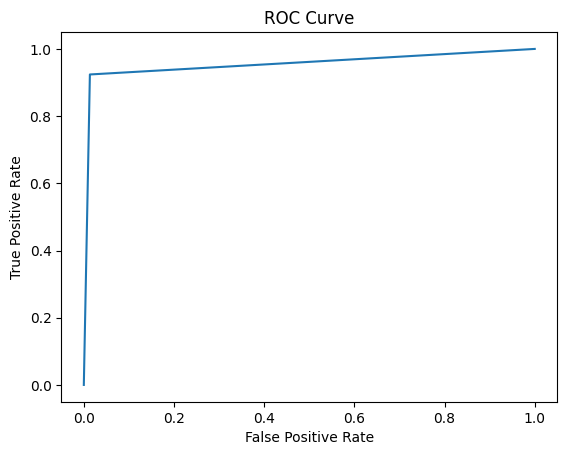

In [11]:
preds = rf.predict(test_x)

print(preds)

fpr, tpr, thresholds = metrics.roc_curve(test_y,preds)
plt.plot(fpr,tpr)
plt.title("ROC Curve")
print("AUC:",metrics.auc(fpr, tpr))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
p,r,f,count = metrics.precision_recall_fscore_support(test_y,preds>0)
print("Accuracy", (test_y == preds).mean())
print("Precision",p)
print("Recall",r)
print("F1",f)
print("Count",count)

### Model 2: SVM

In [12]:
svm = SVC(tol=1e-1)
svm.fit(train_x, train_y)

SVC(tol=0.1)

AUC: 0.9708723776901553
Accuracy 0.9783
Precision [0.97960051 0.97517851]
Recall [0.98955352 0.95219124]
F1 [0.98455186 0.96354779]
Count [6988 3012]


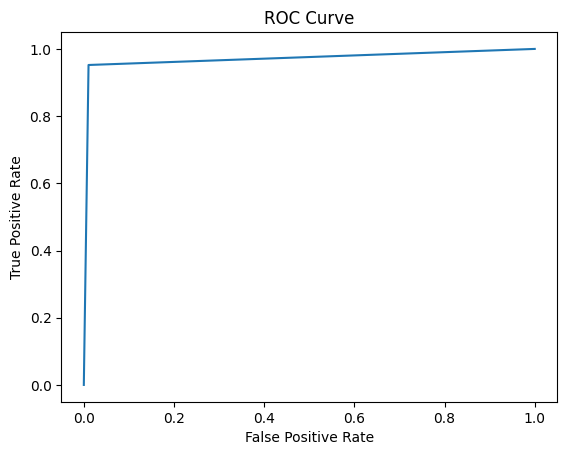

In [13]:
preds = svm.predict(test_x)

fpr, tpr, thresholds = metrics.roc_curve(test_y,preds)
plt.plot(fpr,tpr)
plt.title("ROC Curve")
print("AUC:",metrics.auc(fpr, tpr))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
p,r,f,count = metrics.precision_recall_fscore_support(test_y,preds>0)
print("Accuracy",(test_y == preds).mean())
print("Precision",p)
print("Recall",r)
print("F1",f)
print("Count",count)

### Results from Logistic Regression

AUC: 0.8307008561822165
Accuracy 0.8748
Precision [0.88631466 0.84161491]
Recall [0.9416142  0.71978752]
F1 [0.91312795 0.77594846]
Count [6988 3012]


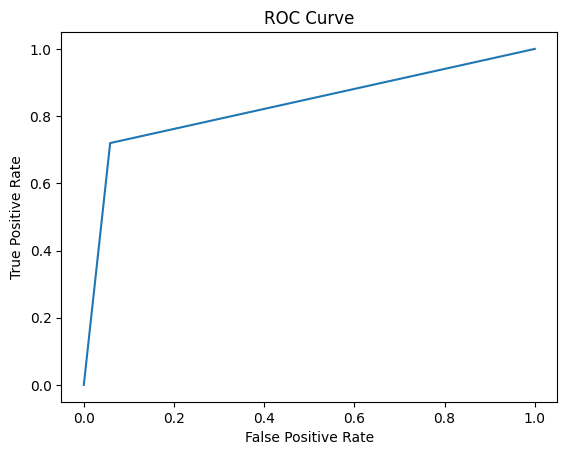

In [14]:
np_labels = model_labels.to('cpu').detach().numpy()
np_preds = model_preds.to('cpu').detach().numpy()

fpr, tpr, thresholds = metrics.roc_curve(np_labels, np_preds)
plt.plot(fpr,tpr)
plt.title("ROC Curve")
print("AUC:",metrics.auc(fpr, tpr))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
p,r,f,count = metrics.precision_recall_fscore_support(np_labels,np_preds>0)
print("Accuracy", (np_preds == np_labels).mean())
print("Precision",p)
print("Recall",r)
print("F1",f)
print("Count",count)

### Analysis

Well I for sure don't think logistic regression is good for this task! <br>
It easily performed worst in almost every category and also took the longest <br> to train to get there! And was also the hardest to implement of the three. <br> As for the other two, its closer. They have very similar scores across the board <br> with SVM slightly edging ahead, however, SVM also takes much longer to fit <br> and predict, so I think that increase classification rate does not do enough to make <br> SVM worth using over something like random forest. 

--------------------------------------------------------------

## **Problem \#3: Multi Layer Model**

### A model that I am using for a project slightly modified

In [15]:
class LeNET(nn.Module):
  def __init__(self, n_classes, epochs, device):
    super().__init__()

    self.extract = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=6, kernel_size=2, stride=1),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=2, stride=1),
        nn.ReLU(),
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=120, kernel_size=2, stride=1),
        nn.ReLU(),
        nn.Flatten()
    )

    self.classify = nn.Sequential(
        nn.Linear(in_features=480, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=100),
        nn.ReLU(),
        nn.Linear(in_features=100, out_features=84),
        nn.ReLU(),
        nn.Linear(in_features=84, out_features=n_classes),
        nn.Softmax()
    )

    self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
    self.criterion = nn.CrossEntropyLoss()

    self.epochs = epochs

    self.device = device


  def forward(self, X):
    X = X.view(-1, 1, 28, 28)
    extr = self.extract(X)

    apreds = self.classify(extr)
    return apreds

  def train(self, X_train, y_train, X_test, y_test):
    batch_size = 32

    yact = torch.zeros(y_train.shape[0], 10)
    for i,val in enumerate(y_train):
      yact[i, val] = 1

    break_count = 0
    max_break_count = 10
    max_acc = 0
    state_dict = None
    for epoch in range(self.epochs):
      total_loss = 0
      indices = torch.randperm(X_train.shape[0])
      X_train = X_train[indices]
      yact = yact[indices]

      for i in range(0, len(X_train), batch_size):
        x = X_train[i:i+batch_size].to(self.device).float()
        y = yact[i:i+batch_size].to(self.device)
        
        self.optimizer.zero_grad()

        pred = self.forward(x)

        loss = self.criterion(pred, y) 
        total_loss += loss.item()

        loss.backward()
        self.optimizer.step()
      
      if ((epoch + 1) % 10 == 0):
        print(f'[{epoch + 1}] Training loss: {total_loss / 10 / X_train.shape[0]}')
        total_loss = 0.0

      acc = 0
      with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
          x = X_test[i:i+batch_size].to(self.device).float()
          y = y_test[i:i+batch_size].detach().numpy()
          
          pred = self.predict(x)
          
          acc += (pred == y).sum()
        
        acc /= X_test.shape[0]
        print(f"[{epoch + 1}] Validation Accuracy: {acc}")
        
        if (acc > max_acc): 
          state_dict = self.state_dict()
          max_acc = acc
          break_count = 0

        if (acc < max_acc):
          break_count += 1 
          if (break_count >= max_break_count):
            self.load_state_dict(state_dict)
            break

        

  def predict(self, x):
    X = x.to(self.device)
    p = np.zeros(x.shape[0])
    preds = self.forward(X)
    preds = preds.to('cpu')

    preds = preds.detach().numpy()
    for i,pred in enumerate(preds):
      p[i] = np.argmax(pred)

    return p

In [16]:
model = LeNET(10, 50, DEVICE).to(DEVICE)

model.train(
    train_dataset.data, 
    train_dataset.targets, 
    test_dataset.data, 
    test_dataset.targets
)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


[1] Validation Accuracy: 0.6785
[2] Validation Accuracy: 0.7657
[3] Validation Accuracy: 0.7697
[4] Validation Accuracy: 0.8584
[5] Validation Accuracy: 0.872
[6] Validation Accuracy: 0.9422
[7] Validation Accuracy: 0.9678
[8] Validation Accuracy: 0.9518
[9] Validation Accuracy: 0.9696
[10] Training loss: 0.004653557670911153
[10] Validation Accuracy: 0.9691
[11] Validation Accuracy: 0.9774
[12] Validation Accuracy: 0.9717
[13] Validation Accuracy: 0.9779
[14] Validation Accuracy: 0.9768
[15] Validation Accuracy: 0.9758
[16] Validation Accuracy: 0.9788
[17] Validation Accuracy: 0.9778
[18] Validation Accuracy: 0.9787
[19] Validation Accuracy: 0.9797
[20] Training loss: 0.004611301457087199
[20] Validation Accuracy: 0.9826
[21] Validation Accuracy: 0.9795
[22] Validation Accuracy: 0.9827
[23] Validation Accuracy: 0.981
[24] Validation Accuracy: 0.9824
[25] Validation Accuracy: 0.9809
[26] Validation Accuracy: 0.9831
[27] Validation Accuracy: 0.9835
[28] Validation Accuracy: 0.9824
[29] 

Testing

In [17]:
preds = model.predict(
    test_dataset.data.float()
)

print("Acc:",(preds==test_dataset.targets.detach().numpy()).mean())

Acc: 0.9839


### Model Explanation

For this model, I decided to use a convolutional architecture that I am also <br> using for a final project in CSCI 5525 that I'm doing for filling out satisfaction surveys <br> using emotions detected on people's faces. Its based on the LeNet architecture <br> and includes 4 convolutional layers, 2 max pools, and 4 linear layers all connected by ReLU <br> activation functions. The training method this time is almost exactly <br> the same as the Logistic Regressor but instead of using a data loader, <br> I just pass all values through in a tensor as it is much faster, <br> especially when done on the GPU. Convolutional layers work really well in <br> situations like this because there are clear features that they can learn <br> as they go across the iamges and the results show just that. <br> The linear layers augment the convolutional layers by kind of <br> decoding their output into a certain category of classification. <br> I was also considering using an autoencoder instead of a CNN <br> to encode into a smaller feature space, but I decided to just keep with this. <br> A 98% accuracy on the testing data which is the highest of the models. <br> Other parameters of the model are Adam with a learning rate of 0.0001 because <br> I tried others and this worked best, and cross entropy loss because duh. <br> Also, the output layer runs through a softmax in order to get it ready for the classification. 

---------------------------------------------------------------------

## **Problem \#4: Visual Analysis**

### Well Classified Digits

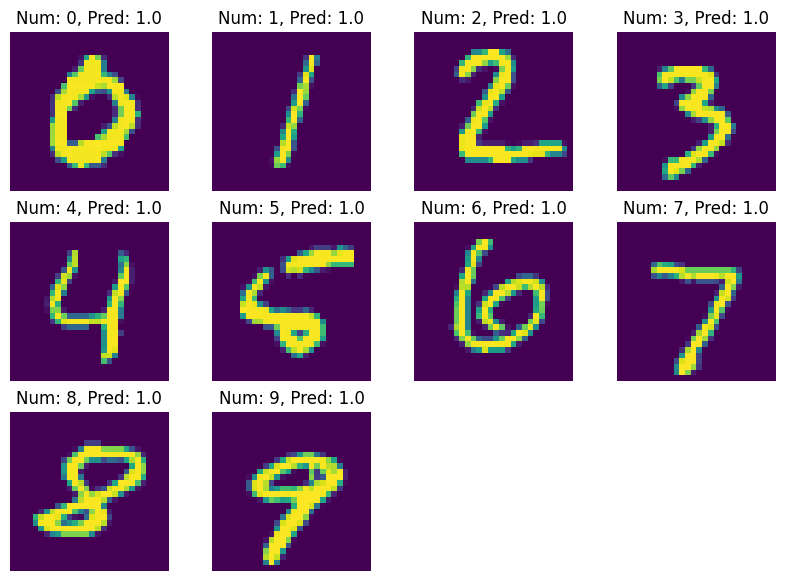

In [18]:
raw_preds = model.forward(
    test_dataset.data.to(DEVICE).float()
)

nums = np.zeros((raw_preds.shape[0],3))
for i,pred in enumerate(raw_preds):
  nums[i,0] = np.argmax(pred.to('cpu').detach().numpy())
  nums[i,1] = pred[int(nums[i,0])]
  nums[i,2] = i

max_data_samples = []
for i in range(10):
  i_s = nums[nums[:,0] == i]
  max = np.argmax(i_s[:,1])
  max_point = i_s[max,:]
  max_data_samples.append((test_dataset.data[int(max_point[2])], max_point[1]))

# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 3
columns = 4

for i,(sample,val) in enumerate(max_data_samples):
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(sample.to('cpu').detach().numpy())
  plt.axis('off')
  plt.title(f"Num: {i}, Pred: {val}")

The above digits look very much like what they "should" look like. <br>
I think the only ones that are a bit weird are 6 and 8. I feel like 6's <br>
more often have a connected, less swirly loop, though, this could be because <br>
there were less 6's and thus weren't able to be classified as well. The 8 is also <br> a bit wobbly which seems a bit odd but it still has the general shape. <br> It is worth noting thought that a lot of the digits had a 1 as their <br> prediction so these may not be the most cannonical. 

### Confusion Matrix

[[ 970    0    1    0    0    1    4    1    1    2]
 [   1 1123    2    3    0    0    1    4    0    1]
 [   2    0 1018    4    0    0    0    7    1    0]
 [   0    0    2  998    0    1    0    6    2    1]
 [   0    0    0    0  969    0    5    1    0    7]
 [   2    0    1    9    0  875    1    1    3    0]
 [   7    1    1    1    3    5  937    0    3    0]
 [   1    2    5    1    0    0    0 1019    0    0]
 [   6    0    4    3    0    1    0    5  951    4]
 [   4    1    0    4    9    3    0    7    2  979]]


<Axes: >

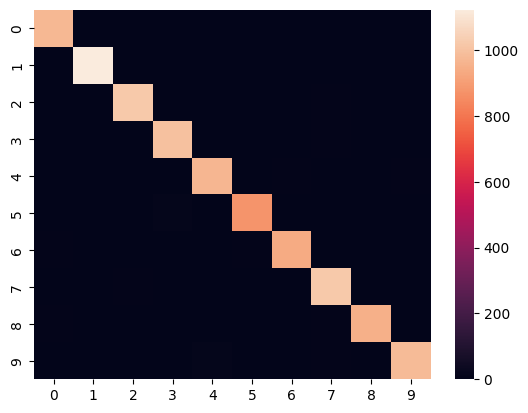

In [19]:
import seaborn as sbn

targs = test_dataset.targets.to('cpu').detach().numpy()
datas = test_dataset.data.to('cpu').detach().numpy()

m = metrics.confusion_matrix(targs,preds)

print(m)

sbn.heatmap(m)

From above, we can see that the most misclassified values are 7, 8, 9, 5, and uhhhhhh 1 I guess. <br> Lets plot those then.

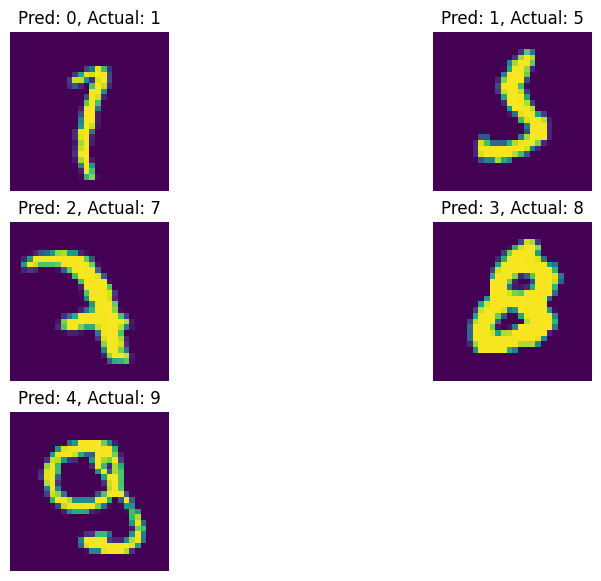

In [20]:
vals = [1,5,7,8,9]
show_data = []
for val in vals:
  show_data.append(
      datas[(preds != val) & (targs == val)][0]
  )

# create figure
fig = plt.figure(figsize=(10, 7))
  
# setting values to rows and column variables
rows = 3
columns = 2

for i,sample in enumerate(show_data):
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(sample)
  plt.axis('off')
  plt.title(f"Pred: {i}, Actual: {vals[i]}")


We can see from these that some are very strange and it makes sense that they were <br> misclassified, like the 1 and the 5, however, others like the 8 and 9 look <br> very much like normal so its weird that they were misclassified. 

-------------------------------------

## **Extra Credit**

In [21]:
# I did this in google colab so if you don't have 
#  gradio and are using that and need to run it 
#  you can just uncomment this below
# !pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 90.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 KB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 KB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 71.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 

In [28]:
import gradio as gr

def do_thing(img):
    transforms = Compose([Normalize((0.1307,), (0.3081,))])
    x = transforms(torch.tensor(img).float().view(1, 1, 28, 28)).to(model.device)
    with torch.no_grad():
        out = model.forward(x)
    out = out.view(10)
    print(out)
    labels = ['0','1','2','3','4','5','6','7','8','9']
    confidences = {labels[i]: v.item() for i, v in enumerate(out)}
    return confidences

gr.Interface(fn=do_thing, 
             inputs="sketchpad",
             outputs="label",
             live=True).launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.

To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([0.0000e+00, 6.9114e-35, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00], device='cuda:0')


Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/gradio/routes.py", line 393, in run_predict
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 1108, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 915, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.9/dist-packages/anyio/to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "<ipython-input-28-feac6187686a>", line 5, in do_thing
    x = transforms(torch.tensor(img).float().view(1, 1, 28, 28)).to(mo

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 1.8121e-39, 0.0000e+00, 1.0000e+00,
        1.7009e-24, 0.0000e+00, 4.4511e-27, 0.0000e+00], device='cuda:0')


Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/gradio/routes.py", line 393, in run_predict
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 1108, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 915, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.9/dist-packages/anyio/to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "<ipython-input-28-feac6187686a>", line 5, in do_thing
    x = transforms(torch.tensor(img).float().view(1, 1, 28, 28)).to(mo

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], device='cuda:0')


Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/gradio/routes.py", line 393, in run_predict
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 1108, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 915, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.9/dist-packages/anyio/to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "<ipython-input-28-feac6187686a>", line 5, in do_thing
    x = transforms(torch.tensor(img).float().view(1, 1, 28, 28)).to(mo

tensor([0.0000e+00, 1.0000e+00, 3.4491e-37, 6.6911e-39, 5.3190e-34, 4.1408e-42,
        8.4078e-45, 1.9036e-40, 3.7429e-42, 0.0000e+00], device='cuda:0')


Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/gradio/routes.py", line 393, in run_predict
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 1108, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 915, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.9/dist-packages/anyio/to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "<ipython-input-28-feac6187686a>", line 5, in do_thing
    x = transforms(torch.tensor(img).float().view(1, 1, 28, 28)).to(mo

tensor([1.0000e+00, 0.0000e+00, 4.8225e-32, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00], device='cuda:0')


Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/gradio/routes.py", line 393, in run_predict
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 1108, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 915, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.9/dist-packages/anyio/to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "<ipython-input-28-feac6187686a>", line 5, in do_thing
    x = transforms(torch.tensor(img).float().view(1, 1, 28, 28)).to(mo

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.6128e-16,
        1.0000e+00, 0.0000e+00, 1.1542e-39, 0.0000e+00], device='cuda:0')


Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/gradio/routes.py", line 393, in run_predict
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 1108, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 915, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.9/dist-packages/anyio/to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "<ipython-input-28-feac6187686a>", line 5, in do_thing
    x = transforms(torch.tensor(img).float().view(1, 1, 28, 28)).to(mo

tensor([2.3137e-11, 0.0000e+00, 2.3800e-34, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        5.7049e-18, 3.3854e-26, 0.0000e+00, 0.0000e+00], device='cuda:0')


Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/gradio/routes.py", line 393, in run_predict
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 1108, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 915, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.9/dist-packages/anyio/to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "<ipython-input-28-feac6187686a>", line 5, in do_thing
    x = transforms(torch.tensor(img).float().view(1, 1, 28, 28)).to(mo

tensor([1.3022e-07, 1.5085e-14, 1.0000e+00, 6.2947e-31, 6.5760e-40, 2.5694e-07,
        1.2611e-23, 1.5110e-19, 2.1653e-24, 2.9935e-40], device='cuda:0')


Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/gradio/routes.py", line 393, in run_predict
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 1108, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 915, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.9/dist-packages/anyio/to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "<ipython-input-28-feac6187686a>", line 5, in do_thing
    x = transforms(torch.tensor(img).float().view(1, 1, 28, 28)).to(mo

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0516e-40, 0.0000e+00, 2.6030e-09,
        9.9998e-01, 0.0000e+00, 2.3456e-05, 0.0000e+00], device='cuda:0')


Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/gradio/routes.py", line 393, in run_predict
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 1108, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 915, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.9/dist-packages/anyio/to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "<ipython-input-28-feac6187686a>", line 5, in do_thing
    x = transforms(torch.tensor(img).float().view(1, 1, 28, 28)).to(mo

tensor([1.9272e-21, 0.0000e+00, 7.3332e-32, 4.1478e-43, 0.0000e+00, 1.0000e+00,
        1.3588e-12, 0.0000e+00, 3.2123e-13, 4.7644e-44], device='cuda:0')


Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/gradio/routes.py", line 393, in run_predict
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 1108, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 915, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.9/dist-packages/anyio/to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "<ipython-input-28-feac6187686a>", line 5, in do_thing
    x = transforms(torch.tensor(img).float().view(1, 1, 28, 28)).to(mo

tensor([8.5319e-04, 6.7202e-18, 9.4926e-20, 3.5822e-22, 2.0602e-18, 9.9915e-01,
        5.0524e-09, 1.5416e-13, 3.8836e-14, 2.9089e-15], device='cuda:0')


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([1.0000e+00, 0.0000e+00, 2.6621e-34, 0.0000e+00, 0.0000e+00, 1.6040e-29,
        7.4779e-10, 0.0000e+00, 0.0000e+00, 0.0000e+00], device='cuda:0')


Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/gradio/routes.py", line 393, in run_predict
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 1108, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 915, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.9/dist-packages/anyio/to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "<ipython-input-28-feac6187686a>", line 5, in do_thing
    x = transforms(torch.tensor(img).float().view(1, 1, 28, 28)).to(mo

tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], device='cuda:0')


Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/gradio/routes.py", line 393, in run_predict
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 1108, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 915, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.9/dist-packages/anyio/to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "<ipython-input-28-feac6187686a>", line 5, in do_thing
    x = transforms(torch.tensor(img).float().view(1, 1, 28, 28)).to(mo

tensor([2.4753e-07, 1.0612e-08, 7.3972e-14, 6.4222e-15, 3.4810e-12, 9.9999e-01,
        5.0541e-06, 9.0857e-07, 2.7514e-11, 5.5327e-10], device='cuda:0')


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([0.0000e+00, 1.5264e-21, 0.0000e+00, 1.8384e-38, 9.9931e-01, 1.3126e-31,
        0.0000e+00, 4.2252e-30, 2.5236e-21, 6.8703e-04], device='cuda:0')


Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/gradio/routes.py", line 393, in run_predict
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 1108, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.9/dist-packages/gradio/blocks.py", line 915, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.9/dist-packages/anyio/to_thread.py", line 31, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.9/dist-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "<ipython-input-28-feac6187686a>", line 5, in do_thing
    x = transforms(torch.tensor(img).float().view(1, 1, 28, 28)).to(mo

tensor([0.0555, 0.3063, 0.2623, 0.0154, 0.0685, 0.0214, 0.0635, 0.0211, 0.1582,
        0.0278], device='cuda:0')


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([1.2089e-06, 1.3378e-03, 3.2120e-07, 3.1402e-08, 9.5597e-08, 1.5254e-01,
        8.4610e-01, 5.4757e-08, 2.2298e-05, 1.8165e-08], device='cuda:0')


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([1.6386e-16, 6.2287e-05, 1.4648e-06, 1.5471e-15, 5.3124e-14, 9.9845e-01,
        1.4831e-03, 1.7342e-13, 1.0715e-23, 3.5777e-18], device='cuda:0')


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([2.1572e-16, 1.2885e-04, 2.0924e-04, 9.2710e-15, 9.3284e-13, 9.9957e-01,
        9.6220e-05, 1.2420e-11, 1.9374e-24, 5.8198e-17], device='cuda:0')


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


tensor([9.9852e-01, 8.6339e-28, 3.2519e-20, 2.4962e-38, 1.0647e-25, 5.9705e-21,
        1.4773e-03, 1.3424e-32, 4.1347e-23, 1.0721e-40], device='cuda:0')
Keyboard interruption in main thread... closing server.
